# ITI105 Machine Learning Project

Team members:
* Lye Suh Jeng (7487427Y)
* Lee Li Neng (6203055B)
* Lim Chan Boon (9704541M)
---
Project Problem: 4 (a) as in suggested project:
* The success of the song can often been measured by whether the song is on the Hit Chart such as Billboard Hot 100. It is important for music labels to know what makes a song successful so that they can focus their budget on making songs that has the highest chance of being successful.
---
We want to solve the problem statement by using the follow steps:
1.   Load dataset
2.   Discover & visualize data to gain insights
3.   Prepare data
4.   Feature scaling
6.   Feature reduction
5.   Split data into train and test datasets
6.   Train, fine tune and evaluate models
7.   Compare performance of models
8.   Deploy the model

# (1) Gather and Load dataset

In [1]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

df = pd.read_csv('https://raw.githubusercontent.com/dy018/project105/main/song_data.csv')

## 2.1 Split features into numeric and categorical features

In [2]:
# song_popularity is target. The rest of columns are features
# Get list of features from df
features = df.columns[1:].tolist()

# put features into 2 types: categorical features and numeric features
category_features = ['audio_mode', 'time_signature', 'key']
numeric_features = [feature for feature in features if feature not in category_features]
print(">>> Categorical features are:", category_features)
print(">>> Numeric features are:", numeric_features)


>>> Categorical features are: ['audio_mode', 'time_signature', 'key']
>>> Numeric features are: ['song_popularity', 'song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']


# (3) Prepare data


In [3]:
# Backup original df
df2 = df.copy()

## (3)(a) Prepare data by removing any duplicat records if any


In [4]:
# Remove duplicate rows (if any)
print(">>>> Original df's shape:", df.shape)

counter = 0
row,col = df.shape

df2.drop_duplicates(inplace=True)

if df2.shape==(row,col):
    print('>>> The dataset doesn\'t have any duplicates')
else:
    print('>>> Number of duplicates dropped/fixed:', {row-df2.shape[0]})
    print(">>> New df2's shape after removing dupliate rows", df2.shape)

>>>> Original df's shape: (18835, 15)
>>> Number of duplicates dropped/fixed: {3909}
>>> New df2's shape after removing dupliate rows (14926, 15)


## (3)(b) Convert categorical features to numeric using dummy encoding

In [5]:
# backup df:
df3 = df2.copy()

# Convert categorical features to numeric using dummy encoding
for feature in category_features:
    dummies = pd.get_dummies(df3[feature], prefix=feature)
    df3 = pd.concat([df3, dummies], axis=1)
    df3.drop(feature, axis=1, inplace=True)

print(">>> df's shape after converting categorical features to numeric using dummy encoding:\n", df3.shape)
print(">>> Columns in new df:\n", df3.columns)
print(">>> First 5 records in new df3:\n")
df3.head()

>>> df's shape after converting categorical features to numeric using dummy encoding:
 (14926, 31)
>>> Columns in new df:
 Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'audio_valence', 'audio_mode_0', 'audio_mode_1',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'key_0', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11'],
      dtype='object')
>>> First 5 records in new df3:



,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,0.0589,-4.095,0.0294,...,False,False,False,False,False,False,True,False,False,False
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,0.1080,-6.407,0.0498,...,False,True,False,False,False,False,False,False,False,False
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0.2550,-7.828,0.0792,...,False,False,False,False,False,False,False,False,False,False
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0.1020,-4.938,0.1070,...,False,False,False,False,False,False,False,False,False,False
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,0.1130,-5.065,0.0313,...,False,False,False,False,False,False,False,False,True,False


# 4) Combine features

In [6]:
df4 = df3.copy()
# combine loudness and energy (correlation  = 0.76)
df4['loudness_energy'] = df4['loudness'] * df4['energy']

# combine danceability and audio_valence (correlation = 0.33)
df4['danceability_av'] = df4['danceability'] * df4['audio_valence']

#drop loudness, energy, danceability, audio_valence
df4.drop(['song_name','loudness', 'energy', 'danceability', 'audio_valence'], axis=1, inplace=True)

print(">>> df's shape after combining features:\n", df4.shape)

>>> df's shape after combining features:
 (14926, 28)


In [7]:
df4.head()

,song_popularity,song_duration_ms,acousticness,instrumentalness,liveness,speechiness,tempo,audio_mode_0,audio_mode_1,time_signature_0,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,loudness_energy,danceability_av
0,73,262333,0.005520,0.000029,0.0589,0.0294,167.060,False,True,False,...,False,False,False,False,True,False,False,False,-2.792790,0.235104
1,66,216933,0.010300,0.000000,0.1080,0.0498,105.256,True,False,False,...,False,False,False,False,False,False,False,False,-5.465171,0.200540
2,76,231733,0.008170,0.447000,0.2550,0.0792,123.881,False,True,False,...,False,False,False,False,False,False,False,False,-3.624364,0.238788
3,74,216933,0.026400,0.003550,0.1020,0.1070,122.444,False,True,False,...,False,False,False,False,False,False,False,False,-4.789860,0.089298
4,56,223826,0.000954,0.000000,0.1130,0.0313,172.011,False,True,False,...,False,False,False,False,False,False,True,False,-3.879790,0.256578


# 5) Feature scaling

In [8]:
# Apply scaling on columns of df
def scaler(temp_df):
  # Initialize the MinMaxScaler
  min_max_scaler = MinMaxScaler()

  # Fit the scaler to the data and transform it
  min_max_scaled_data = min_max_scaler.fit_transform(temp_df)

  temp_df = pd.DataFrame(min_max_scaled_data, columns=temp_df.columns)
  return temp_df

Y = df4['song_popularity']

X_scaled = scaler(df4.drop(['song_popularity'], axis=1))

print (">>> Display first 5 records of training data after scaling:\n")
X_scaled.head()

>>> Display first 5 records of training data after scaling:



,song_duration_ms,acousticness,instrumentalness,liveness,speechiness,tempo,audio_mode_0,audio_mode_1,time_signature_0,time_signature_1,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,loudness_energy,danceability_av
0,0.140059,0.005541,0.000029,0.049226,0.031243,0.689425,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.714949,0.252207
1,0.114658,0.010340,0.000000,0.099580,0.052922,0.434371,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.539481,0.215128
2,0.122938,0.008202,0.448345,0.250333,0.084166,0.511233,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.660348,0.256159
3,0.114658,0.026505,0.003561,0.093426,0.113709,0.505303,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583822,0.095794
4,0.118514,0.000957,0.000000,0.104707,0.033262,0.709856,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.643577,0.275243


In [9]:
print (">>> Display df's statistic after scaling:\n")
X_scaled.describe()

>>> Display df's statistic after scaling:



,song_duration_ms,acousticness,instrumentalness,liveness,speechiness,tempo,audio_mode_0,audio_mode_1,time_signature_0,time_signature_1,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,loudness_energy,danceability_av
count,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,...,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000,14926.000000
mean,0.115786,0.271538,0.092344,0.173864,0.105652,0.499777,0.368083,0.631917,0.000201,0.004489,...,0.072625,0.084215,0.070213,0.110813,0.070146,0.094466,0.070012,0.081804,0.620629,0.367743
std,0.034879,0.299315,0.241174,0.148803,0.110038,0.119862,0.482300,0.482300,0.014176,0.066850,...,0.259529,0.277720,0.255514,0.313911,0.255402,0.292486,0.255176,0.274074,0.098197,0.212455
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.096200,0.023694,0.000000,0.084196,0.039532,0.404943,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.568219,0.194664
50%,0.111811,0.139557,0.000021,0.113937,0.057492,0.495283,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.631436,0.345284
75%,0.130204,0.459839,0.005120,0.218542,0.120085,0.577509,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.682854,0.523929
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 6) Feature reduction using VIF

In [10]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 9.2 MB/s eta 0:00:00


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

DROP=[];

for i in range(len(X_scaled.columns)):
    vif = pd.DataFrame()
    vif['Features'] = X_scaled.columns
    vif['VIF'] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)

vif

,Features,VIF
0,time_signature_0,inf
1,time_signature_1,inf
2,audio_mode_0,inf
3,time_signature_3,inf
4,audio_mode_1,inf
5,key_3,inf
6,key_2,inf
7,key_1,inf
8,key_0,inf
9,time_signature_5,inf


### Observation from VIF table:
* features that has VIF more than 5 shall be removed.

In [12]:
tobe_drop = vif[(vif['VIF'] > 5)]['Features'].tolist()
print(tobe_drop)

['time_signature_0', 'time_signature_1', 'audio_mode_0', 'time_signature_3', 'audio_mode_1', 'key_3', 'key_2', 'key_1', 'key_0', 'time_signature_5', 'time_signature_4', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'key_4', 'key_5']


In [13]:
X_vif = X_scaled.drop(tobe_drop, axis=1)
print(X_vif.shape)
X_vif.head()

(14926, 8)


,song_duration_ms,acousticness,instrumentalness,liveness,speechiness,tempo,loudness_energy,danceability_av
0,0.140059,0.005541,0.000029,0.049226,0.031243,0.689425,0.714949,0.252207
1,0.114658,0.010340,0.000000,0.099580,0.052922,0.434371,0.539481,0.215128
2,0.122938,0.008202,0.448345,0.250333,0.084166,0.511233,0.660348,0.256159
3,0.114658,0.026505,0.003561,0.093426,0.113709,0.505303,0.583822,0.095794
4,0.118514,0.000957,0.000000,0.104707,0.033262,0.709856,0.643577,0.275243


# Split data into training and testing datasets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_vif, Y, train_size=0.8, test_size=0.2, random_state=40)
X_train.reset_index(drop=True,inplace=True)

print(">>> Size of trainig set: ", X_train.shape)
print(">>> Size of testing set: ", X_test.shape)

>>> Size of trainig set:  (11940, 8)
>>> Size of testing set:  (2986, 8)


# 6.  Train, fine tune, and evaluate model's performance

## Model Evaluation Functions

In [15]:
# calculates r2_score
def cal_r2(y_true, y_pred):
  r2 = r2_score(y_true, y_pred)
  return r2

# Calculates adjusted_r2
def cal_adj_r2(x_df, r2):
  number_variables = x_df[1] - 1
  adjusted_r2 = 1 - ((1-r2) * (x_df[0]-1)) / (x_df[0] - number_variables -1)
  return adjusted_r2

def cal_mse(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  return mse

def cal_performance(x_train_shape, x_test_shape, y_train, y_train_pred, y_test, y_test_pred):
  r2_train = cal_r2(y_train, y_train_pred)
  r2_test = cal_r2(y_test, y_test_pred)
  adj_r2_train = cal_adj_r2(x_train_shape, r2_train)
  adj_r2_test = cal_adj_r2(x_test_shape, r2_test)
  mse_train = cal_mse(y_train, y_train_pred)
  mse_test = cal_mse(y_test, y_test_pred)

  performance_dict = {
    'r2_train': r2_train,
    'r2_test': r2_test,
    'adj_r2_train': adj_r2_train,
    'adj_r2_test': adj_r2_test,
    'mse_train': mse_train,
    'mse_test': mse_test
    }
  return performance_dict

In [16]:

from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest Regressor
rf = RandomForestRegressor(random_state=40)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Make predictions
rf_pred_train = best_rf.predict(X_train)
rf_pred_test = best_rf.predict(X_test)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [17]:
# Evaluate the model
rf_performance = cal_performance(X_train.shape, X_test.shape, y_train, rf_pred_train, y_test, rf_pred_test)
print(rf_performance)

{'r2_train': 0.26166044143199463, 'r2_test': 0.050635734449631764, 'adj_r2_train': 0.2612272888247221, 'adj_r2_test': 0.048404186478223865, 'mse_train': 306.57092741190843, 'mse_test': 394.55486959474274}


In [18]:
# convert dictionary to dataframe
rf_df = pd.DataFrame.from_dict(rf_performance, orient='index', columns=['RF'])

print(">>> Model performance:\n")
rf_df

>>> Model performance:



,RF
r2_train,0.261660
r2_test,0.050636
adj_r2_train,0.261227
adj_r2_test,0.048404
mse_train,306.570927
mse_test,394.554870


# Validation



In [19]:
print(y_test[0:10].values)
print(rf_pred_test[:10])

[55 51 72 56 73 58 60 16 38 95]
[51.04216836 54.16793846 47.76101238 48.49360674 50.85837202 46.71955688
 46.47860102 42.82540365 47.20733109 57.43135061]


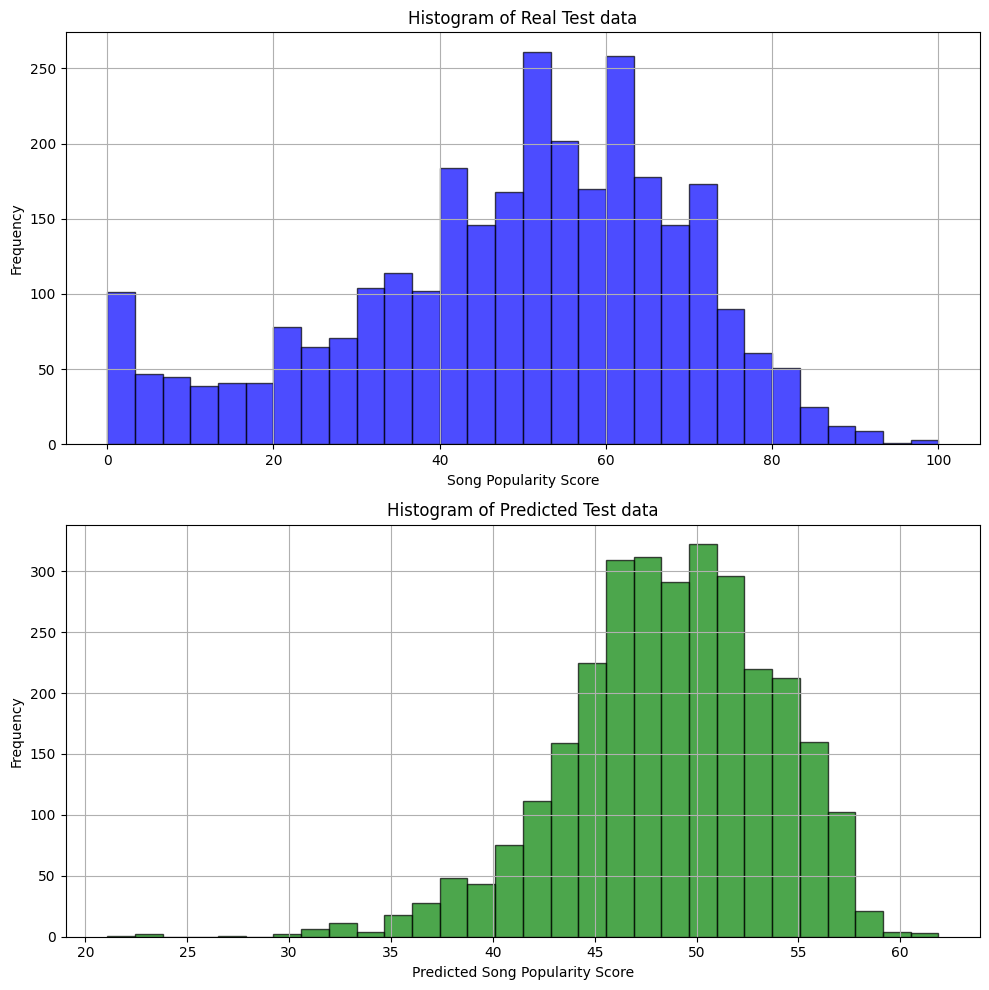

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the first histogram on the first subplot
ax1.hist(y_test, bins=30, color='blue', alpha=0.7, edgecolor='black')
ax1.set_title('Histogram of Real Test data')
ax1.set_xlabel('Song Popularity Score')
ax1.set_ylabel('Frequency')
ax1.grid(True)

# Plot the second histogram on the second subplot
ax2.hist(rf_pred_test, bins=30, color='green', alpha=0.7, edgecolor='black')
ax2.set_title('Histogram of Predicted Test data')
ax2.set_xlabel('Predicted Song Popularity Score')
ax2.set_ylabel('Frequency')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# 7. Deployment

## 7.1 Convert the Model to a Pickle File

In [27]:
import pickle

# Save the trained model to a pickle file
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)


## 7.2 Set Up Gradio for Deployment

In [28]:
#Gradio provides a simple interface to create a web application for your model
!pip install gradio


In [39]:
def predict_song_popularity(song_duration_ms, acousticness, instrumentalness, liveness, speechiness, tempo, loudness_energy, danceability_av):
    # Your prediction code here
    pass




In [53]:
import gradio as gr
import pickle

# Load the pre-trained model (assuming you have already trained and saved it as 'song_popularity_model.pkl')
with open('song_popularity_model.pkl', 'rb') as f:
    best_rf = pickle.load(f)

def predict_song_popularity(song_duration_ms, acousticness, instrumentalness, liveness, speechiness, tempo, loudness_energy, danceability_av):
    # Make the prediction using the model
    predicted_score = best_rf.predict([[song_duration_ms, acousticness, instrumentalness, liveness, speechiness, tempo, loudness_energy, danceability_av]])[0]

    # Define the interpretation of the score
    if predicted_score >= 75:
        interpretation = "This song is predicted to be very popular!"
    elif predicted_score >= 50:
        interpretation = "This song is predicted to have moderate popularity."
    else:
        interpretation = "This song is predicted to have low popularity."

    # Additional explanation
    explanation = "Scores closer to 100 indicate higher popularity, while scores closer to 0 suggest lower popularity. This prediction is based on features like acousticness, instrumentalness, and more."

    return predicted_score, interpretation, explanation

def create_interface():
    # Define the inputs
    inputs = [
        gr.Slider(minimum=0, maximum=1000000, label="Song Duration (ms)"),
        gr.Slider(minimum=0, maximum=1, label="Acousticness"),
        gr.Slider(minimum=0, maximum=1, label="Instrumentalness"),
        gr.Slider(minimum=0, maximum=1, label="Liveness"),
        gr.Slider(minimum=0, maximum=1, label="Speechiness"),
        gr.Slider(minimum=0, maximum=300, label="Tempo (BPM)"),  # Adjusted max value for tempo
        gr.Slider(minimum=0, maximum=1, label="Loudness Energy"),
        gr.Slider(minimum=0, maximum=1, label="Danceability"),
    ]

    # Define the outputs
    outputs = [
        gr.Textbox(label="Predicted Popularity Score"),
        gr.Textbox(label="Interpretation"),
        gr.Textbox(label="Explanation")
    ]

    # Create the Gradio interface with 5 repeated images
    interface = gr.Interface(
        fn=predict_song_popularity,
        inputs=inputs,
        outputs=outputs,
        title="Project 105 - Song Popularity Predictor",
        description="Predicts the popularity of a song based on various features.",
        theme="default",
        article="""
        <div style="display: flex; justify-content: space-between;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
            <img src="https://media.licdn.com/dms/image/C4E12AQExrMZNbhgbUQ/article-cover_image-shrink_720_1280/0/1603886622981?e=2147483647&v=beta&t=5HfqYsIJi8urgn9jw47xWWUVOd6dWHwMk4EUy8dq-2s" style="width: 150px; height: 150px;">
        </div>
        <br><br>
        Use this tool to predict how popular a song might be based on its characteristics. The popularity score ranges from 0 to 100, with higher scores indicating greater potential popularity. Consider features like acousticness, instrumentalness, and more to understand what makes a song resonate with listeners.
        """
    )

    return interface

# Launch the interface
interface = create_interface()
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0bc0fa783a001798f5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
